Script to automatically extract training data based on template matching from a single input file. There is a separate script (generate_training_data_multiple_recordings.py) to extract training data from several files or recordings. Here, we use a single file and plot the result obtained by template matching as well as the template. Can be used to adjust parameters.

In [4]:
import sys
sys.path.append('../../core/')

from miniML import MiniTrace
import template_matching as tm
import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy
from scipy import signal

import matplotlib
%matplotlib inline

Data loaded from ../../example_data/EEG_part2.h5 with shape (1, 60077)


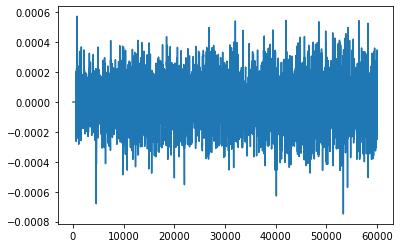

In [9]:
path = '../../example_data/'
myfile = 'EEG_part2.h5'
save_id = 'EEG_part2'
filename = path+myfile
scaling =  0.002
unit = 'mV'

# get from h5 file
trace = MiniTrace.from_h5_file(filename=filename,
                               tracename='partial',
                               scaling=scaling,
                               unit=unit)

plt.plot(trace.data)
plt.show()

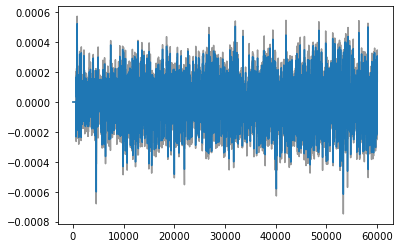

In [18]:
# For template matching it can be useful to filter the data. We use a Hann window here.
filter_data = True
if filter_data:
    win = signal.windows.hann(13)
    tmplt_trace = signal.convolve(trace.data, win, mode='same') / sum(win)
else:
    tmplt_trace = trace.data

plt.plot(trace.data, c='k', alpha=0.4)
plt.plot(tmplt_trace)
plt.show()

Template matching is dependent on the waveform that is used as template. We first use a very rough estimate based on the provided window size to extract a few events from the data. We can use those to adjust the template (see below).

To be able to estimate the parameters we need to scale the event. To scale it, we do a baseline subtraction, and divide by the minimum value. This assumes that the event is a negative deflection. For positive events, this needs to be change to the maximum value.

In [14]:
print (int(win_size*2/3) * trace.sampling)

0.008


found 0 events


c:\Users\PalopLabPortal\Documents\Dakota\mminiml\miniML\model_training\extract_training_data\../../core\template_matching.py:102: RuntimeWarning: invalid value encountered in true_divide
  crit = s_n / (sse_n / (N - 1)) ** 0.5
c:\Users\PalopLabPortal\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\PalopLabPortal\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: invalid index to scalar variable.

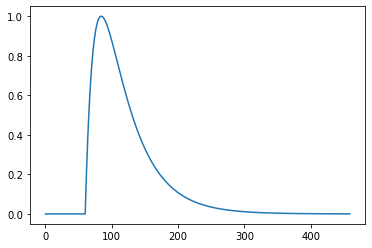

In [19]:
# Estimate roughly event shape based on window size; can be adjusted later
win_size = 600
baseline = (win_size/10) * trace.sampling
duration = int(win_size*2/3) * trace.sampling
t_rise = (baseline+(win_size * trace.sampling))/30
t_decay = (baseline+(win_size * trace.sampling))/15

template = tm.make_template(t_rise=t_rise, t_decay=t_decay, baseline=baseline, duration=duration, sampling=trace.sampling)
plt.plot(template, label='template')


# Run template matching to extract a few events to adjust template.
matching = tm.template_matching(tmplt_trace, template, threshold=-4)
print(f'found {len(matching.indices)} events')

# Get average event form
events = []
for ind in matching.indices:
    if ind < tmplt_trace.shape[0] - win_size:
        events.append(tmplt_trace[ind:ind+win_size])
events = np.array(events)

mean_ev = np.mean(events, axis=0)

# Scale the event
mean_ev -= np.mean(mean_ev[0:int(win_size/10)])
mean_ev /= np.min(mean_ev) # Needs to be adjusted for positive events.
plt.plot(template, label='template')
plt.plot(mean_ev,label='event')
plt.legend()
plt.show()

In the cell below you can adjust the template. It does not have to be perfect, a rough fit suffices. Just change the values by which t_rise and t_decay are divided until the template and the average event more or less fit. If the event is shifted, it is also possible to shorten the duration or change values for baseline to make it fit btter. Because this is a jupyter notebook, you can just rerun the cell as many times as you need, until you found satisfactory values.

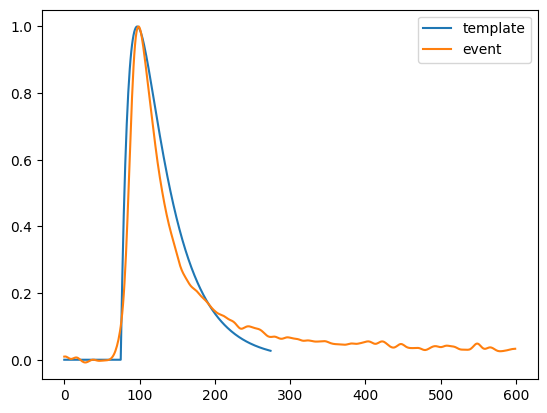

In [5]:
%matplotlib inline
# Plot template and average event and use this to adjust template.
baseline = (win_size/8) * trace.sampling
duration = int(win_size*1/3) * trace.sampling
t_rise = (baseline+(win_size * trace.sampling))/40
t_decay = (baseline+(win_size * trace.sampling))/15

template = tm.make_template(t_rise=t_rise, t_decay=t_decay, baseline=baseline, duration=duration, sampling=trace.sampling)
plt.plot(template, label='template')
plt.plot(mean_ev,label='event')
plt.legend()
plt.show()

Next, we extract events with a relatively high threshold (Default is -4.5). Again, performance does not need to be good, it is only important that events are not systematically missed.

In [6]:
cell_label, idx, events, scores = [], [], [], []

# Set the different thresholds.
threshold_high = -4.5
threshold_mid = -3
threshold_low = -1.5


# Run template matching with a high threshold to extract events with high confidence.
matching = tm.template_matching(tmplt_trace, template, threshold=threshold_high)
print(f'found {len(matching.indices)} events with high threshold')

found 86 events with high threshold


The %matplotlib inline command can be changed to %matplotlib qt to make the plot interactive and zoom into the trace.

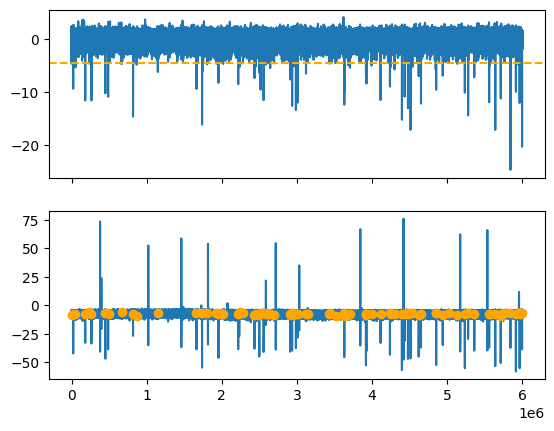

In [7]:
%matplotlib inline

# Plot the output to make sure the result makes sense
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(matching.detection_trace)
axs[0].axhline(threshold_high, c='orange', zorder=2, ls='--')
axs[1].plot(trace.data)
axs[1].scatter(matching.indices, tmplt_trace[matching.indices], c='orange', zorder=2)
plt.show()

In [8]:
# Extract clear events
event_counter = 0
for ind, location in enumerate(matching.indices):
    if location < trace.data.shape[0] - int(win_size*1.5):
        event = copy.deepcopy(trace.data[location:location+win_size])
        event -= np.mean(event[:int(win_size/10)])
        
        cell_label.append(filename)
        idx.append(location)
        events.append(event)
        scores.append(1)
        event_counter += 1

print(f'{event_counter} events extracted\n')


# generate list with all indices of +/- (win_size/30) points of the previously found events to prevent duplicates (or at least keep them to a minimum)
idx_range = []
buffer = int(win_size/30)
for my_ind in idx:
    idx_range += list(range(my_ind-buffer, my_ind+buffer))

# Run tmplt matching with a relatively low threshold to extract FPs and small events.
matching = tm.template_matching(tmplt_trace, template, threshold=threshold_mid)
print(f'found {len(matching.indices)} events with mid threshold')
unclear_counter = 0
for ind, location in enumerate(matching.indices):
    if location < trace.data.shape[0] - int(win_size*1.5):
        if location not in idx_range:
            event = copy.deepcopy(trace.data[location:location+win_size])
            event -= np.mean(event[:int(win_size/10)])
            
            cell_label.append(filename)
            idx.append(location)
            events.append(event)
            scores.append(2)
            unclear_counter += 1

print(f'{unclear_counter} unclear events extracted\n')

86 events extracted

found 444 events with mid threshold
358 unclear events extracted



In [9]:
# Run tmplt matching with a very low threshold. Remaining parts of the trace should be event free.
matching = tm.template_matching(tmplt_trace, template, threshold=threshold_low)
print(f'found {len(matching.indices)} events with low threshold')

event_free_indices = []
for i in range(matching.indices.shape[0]-1):
    start = matching.indices[i] + win_size
    end = matching.indices[i+1] - win_size
    if end - start > 0:
        event_free_indices.append(np.arange(start, end))

event_free_indices = np.concatenate(event_free_indices)
unique_stretches = []
for ind, i in enumerate(event_free_indices):
    if ind==0:
        unique_stretches.append(i)
        next_possible = i+win_size
    
    if i < next_possible:
        pass
    else:
        unique_stretches.append(i)
        next_possible = i+win_size

# Extract unique stretches to prevent overlap and redundancy in the data
if len(unique_stretches) <= event_counter:
    inds = np.array(unique_stretches)
else:
    inds = np.random.choice(np.array(unique_stretches), event_counter, replace=False)

# Extract events
noise_counter = 0
for location in sorted(inds):
    event = copy.deepcopy(trace.data[location:location+win_size])
    event -= np.mean(event[:int(win_size/10)])
    cell_label.append(filename)
    idx.append(location)
    events.append(event)
    scores.append(0)
    noise_counter += 1

print(f'{noise_counter} noise stretches extracted')

found 6090 events with low threshold
3544
86 noise stretches extracted


In [10]:
# Save the result
x = np.array(events)
y = np.array(scores)
indices = np.array(idx)

save_dataset = f'./output/{save_id}_example_training_data.h5'

if save_dataset:
    with h5py.File(save_dataset, 'w') as f:
        f.create_dataset("events", data=x)
        f.create_dataset("scores", data=y)
        f.create_dataset("raw_indices", data=indices)
        f.create_dataset("cell_label", data=np.array(cell_label, dtype='S'))